## 분석
- train은 15951 그 중 양성: 2158 음성: 13793
- test는 400 그 중 양성 198 음성: 202
- 사진 데이터의 크기는 제각각 -> 이는 500 x 500의 BGR 3채널 데이터로 resize를 진행한다.
- 사진 데이터 1개를 resize해서 메모리에 올리면 대략 0.73MB가 증가 -> 1000개를 불러서 array에 저장했을 때 732.55MB
- 학습 컨테이너를 만들자. 학습 컨테이너에서 데이터를 읽어서 저장(block_size) -> 학습 함수 호출 -> 반복
- 학습 함수를 만들어서 parameter로 각종 정보를 가지는 dict 자료형을 사용해보자
- 학습 함수에는 모델, batch_size(한번에 학습시킬 데이터 수), 학습 데이터를 받아서 사용
- 여기에서 sci-kit learn의 train_test_split을 사용해보자!
- split하고 train은 기존 데이터를 사용하고 test데이터를 validation 데이터로 사용
- ex) 1000개 중 200개를 validation 데이터로 사용하되 학습은 1000개 모두 사용.

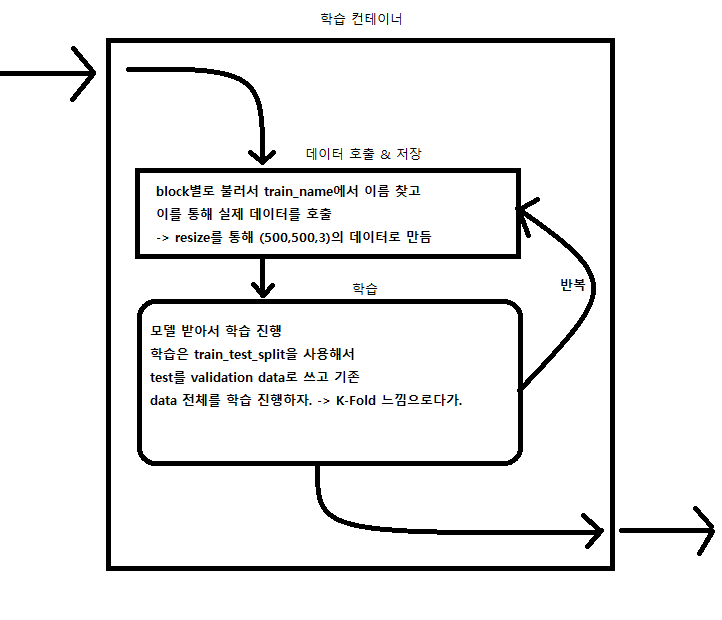

In [1]:
import pandas as pd
import cv2
import time
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# !pip install memory_profiler
%load_ext memory_profiler
%memit

peak memory: 266.32 MiB, increment: 0.08 MiB


In [3]:
class COVID:
    def __init__(self):
        # initialization
        self.train = pd.read_csv('./COVID_XRAY/train.txt',sep = " ", engine='python',header=None)
        self.test = pd.read_csv('./COVID_XRAY/test.txt',sep = " ", engine='python',header= None)
        self.__train_path = './COVID_XRAY/train/'
        self.__test_path = './COVID_XRAY/test/'
        self.__data_size = 250
        self.__seed = 123
        self._data_shuffle()
    
    def _data_shuffle(self):
        # data shuffle
        self.train = self.train.sample(frac=1, replace=True, random_state=self.__seed)
        self.test = self.test.sample(frac=1, replace=True, random_state=self.__seed)
        self._data_extraction()
    
    def _data_extraction(self):
        # data name and label divide
        self.__train_name = self.train.iloc[:,1]
        self.__train_label = self.train.iloc[:,2]
        self.__test_name = self.test.iloc[:,1]
        self.__test_label = self.test.iloc[:,2]
        self._encoding()
        
    def _encoding(self):
        encoder = LabelEncoder()
        self.__train_label = encoder.fit_transform(self.__train_label)
        self.__test_label = encoder.fit_transform(self.__test_label)
        self._data_verification()
        
    def _data_verification(self):
        # data information 출력
        print('train:',self.train.head())
        print('test:',self.test.head())
        print('size of train data :', len(self.__train_name))
        print('size of test data :', len(self.__test_name))
        print('train data pos vs neg ratio :', self.train[2].value_counts())
        print('test data pos vs neg ratio :', self.test[2].value_counts())
    
    def show_data_example(self):
        # 이미지 데이터 불러서 예시로 확인해보기.
        data = cv2.imread(self.__train_path + self.__train_name[0],cv2.IMREAD_COLOR)
        data = cv2.resize(data, (self.__data_size,self.__data_size), interpolation = cv2.INTER_AREA)
        data_r = data[:,:,0]
        data_g = data[:,:,1]
        data_b = data[:,:,2]
        cv2.imshow('original', data)
        cv2.imshow('r_channel', data_r)
        cv2.imshow('g_channel', data_g)
        cv2.imshow('b_channel', data_b)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def modeling(self):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(self.__data_size,self.__data_size,3))) #82개의 3x3 matrix filters)
        self.model.add(keras.layers.MaxPool2D((2,2))) #2x2 size의 Max Pooling 2D Matrix
        self.model.add(keras.layers.Dropout(0.2)) #0.2%의 확률로 dropout
        self.model.add(keras.layers.Conv2D(128,(3,3),activation='relu')) # 전 단계 필터 수의 2배인 164개의 3x3 matrix filters
        self.model.add(keras.layers.MaxPool2D((2,2))) #2x2 size의 Max Pooling 2D Matrix
        self.model.add(keras.layers.Dropout(0.3)) #0.3%의 확률로 dropout
        self.model.add(keras.layers.Flatten()) #dropout했을 때의 차원과 filter 개수를 곱해서 쭉 늘임
        self.model.add(keras.layers.Dense(64,activation='relu'))
        self.model.add(keras.layers.Dense(32,activation='relu'))
        self.model.add(keras.layers.Dense(16,activation='relu'))
        self.model.add(keras.layers.Dense(1,activation='sigmoid'))
        self.model.compile(optimizer='adam',#정규화기
              loss='binary_crossentropy', #손실함수
              metrics=['accuracy','Precision','Recall']) #기준리스트
        self.model.summary()
        keras.utils.plot_model(self.model, show_shapes=True)
    
    # data load
    def __data_loading(self,start = 0,end = 500,typ='tr'):
        # start : index of start block -> ex) 0
        # end : index of end block -> ex) 1000
        if typ == 'tr':
            name_list = self.__train_name
            path = self.__train_path
        elif typ == 'te': # typ == 'te'
            name_list = self.__test_name
            path = self.__test_path
            start = 0
            end = len(self.__test_name)
        else:
            return None
        print('loading start')
        image = []
        start_time = time.time()
        for i, name in enumerate(name_list):
#             print(r'{0}'.format(i))
            if i < start:
                continue
            if i > end :
                break;
            fname = path + name
            data = cv2.imread(fname,cv2.IMREAD_COLOR)
            data = cv2.resize(data, (self.__data_size,self.__data_size), interpolation = cv2.INTER_AREA)
            image.append(data)
#         %memit
        image = np.array(image)
        print('Time Eleapsed: {0:.4}ms'.format(time.time()-start))
        print(image.shape)
        return image
    # train
    def __train(self,start,end,data):
        #data = data
#         print(self.__train_label.shape)
        label = self.__train_label[start:end+1]
        print(label.shape)
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=self.__seed)
        %memit
        self.model.fit(data,label,epochs = 5, validation_data=(x_test,y_test))
        %memit
        
    def train_container(self):
        block_size = 1000
        num_block = round(len(self.__train_name)/block_size)
        epochs = 10
        self.modeling()        
        

        for epoch in range(epochs):
#             self._data_shuffle()
            print("epoch {0}:".format(epoch))
            for iteration in range(num_block):
                start = iteration * block_size
                end = (iteration+1) * block_size
                print("    block {0}:".format(iteration))
                data = self.__data_loading(start,end, typ = 'tr')
                %memit
                self.__train(start,end,data)

                
    def test(self):
        data = self.__data_loading(typ='te')
        self.model.evaluate(data , self.__test_label)
    
    def predict(self):
        prediction = self.model.predict(self.__data_loading(typ='te'))
        return prediction, self.__test_label


In [4]:
test = COVID()

train:                                           0  \
3582   3ffd6f8f-a701-46b4-8720-806cb7332718   
15725  1462ffd1-939b-49b7-9234-eeeb7f4986cc   
11646  3ddfe89f-2b00-49cc-ad50-30ac45c8aad2   
1346                              COVID_641   
12252  65b87566-709e-4b0f-b4bb-55020515f6e7   

                                              1         2     3  
3582   3ffd6f8f-a701-46b4-8720-806cb7332718.png  negative  rsna  
15725  1462ffd1-939b-49b7-9234-eeeb7f4986cc.png  negative  rsna  
11646  3ddfe89f-2b00-49cc-ad50-30ac45c8aad2.png  negative  rsna  
1346                             COVID(641).png  positive  sirm  
12252  65b87566-709e-4b0f-b4bb-55020515f6e7.png  negative  rsna  
test:                                         0  \
365  8ae822ae-a656-47ba-ac5b-848ce2256575   
382  a6236ddd-6367-4569-b5f1-07d2df9390ad   
322  e1d5a233-39ca-41dc-a289-b07c3e78cdb1   
98                          419639-003060   
230  d3ad2915-af30-426c-ad2d-1634df8c1b5f   

                                     

In [5]:
%memit

peak memory: 275.66 MiB, increment: 0.00 MiB


규모가 너무 커서 16GB램이 터지려고 함...

이 부분은 Google Colab에서 학습을 진행하려하니 구글드라이브가 말썽이라 드라이브 100GB 결제함...

In [6]:
test.train_container()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 476288)            0

Epoch 7/10
32/32 [==============================] - 81s 3s/step - loss: 0.1430 - accuracy: 0.9680 - precision: 0.8676 - recall: 0.8939 - val_loss: 0.2086 - val_accuracy: 0.9751 - val_precision: 0.9000 - val_recall: 0.9730
Epoch 8/10
32/32 [==============================] - 81s 3s/step - loss: 0.1125 - accuracy: 0.9710 - precision: 0.8992 - recall: 0.8788 - val_loss: 0.0695 - val_accuracy: 0.9900 - val_precision: 1.0000 - val_recall: 0.9459
Epoch 9/10
32/32 [==============================] - 81s 3s/step - loss: 0.0870 - accuracy: 0.9740 - precision: 0.9417 - recall: 0.8561 - val_loss: 0.0417 - val_accuracy: 0.9950 - val_precision: 1.0000 - val_recall: 0.9730
Epoch 10/10
32/32 [==============================] - 81s 3s/step - loss: 0.0544 - accuracy: 0.9890 - precision: 0.9690 - recall: 0.9470 - val_loss: 0.0376 - val_accuracy: 0.9900 - val_precision: 1.0000 - val_recall: 0.9459
peak memory: 1044.79 MiB, increment: 0.00 MiB
epoch 3:
loading start
Time Eleapsed: 1.623e+09ms
(1001, 250, 250

peak memory: 1044.66 MiB, increment: 0.00 MiB
epoch 6:
loading start
Time Eleapsed: 1.623e+09ms
(1001, 250, 250, 3)
peak memory: 865.07 MiB, increment: 0.00 MiB
(1001,)
peak memory: 1044.07 MiB, increment: 0.00 MiB
Epoch 1/10
32/32 [==============================] - 89s 3s/step - loss: 0.4620 - accuracy: 0.8721 - precision: 0.5294 - recall: 0.4667 - val_loss: 0.1348 - val_accuracy: 0.9403 - val_precision: 0.6522 - val_recall: 0.7895
Epoch 2/10
32/32 [==============================] - 87s 3s/step - loss: 0.2005 - accuracy: 0.9081 - precision: 0.6807 - recall: 0.6000 - val_loss: 0.1122 - val_accuracy: 0.9552 - val_precision: 0.7083 - val_recall: 0.8947
Epoch 3/10
32/32 [==============================] - 88s 3s/step - loss: 0.1464 - accuracy: 0.9281 - precision: 0.7368 - recall: 0.7259 - val_loss: 0.0557 - val_accuracy: 0.9652 - val_precision: 0.7727 - val_recall: 0.8947
Epoch 4/10
32/32 [==============================] - 87s 3s/step - loss: 0.1026 - accuracy: 0.9500 - precision: 0.8632 -

KeyboardInterrupt: 

In [7]:
test.test()

TypeError: 'DataFrame' object is not callable